# Spectral Curvature

## Libraries

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForCausalLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

## Model -- DialoGPT


In [ ]:
MODEL_NAME = "microsoft/DialoGPT-medium"  # you can switch to small/large
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32
EPS_DIST = 1e-12              # floor for probabilities before sqrt
EPS_CURV = 1e-12              # epsilon in the curvature denominator

PROMPT1 = "The artist drew a landscape with a river flowing towards the mountains."
PROMPT2 = "इसे आज़माने के लिए, नीचे अपनी भाषा और इनपुट उपकरण चुनें और लिखना आरंभ करें|"
PROMPT3 = "أنا ملك عالمي الخاص ولا أجرؤ على إجباري على تلبية احتياجات من اختيارك"
PROMPT4 = "श्वः अतीव द्रुतं धावति"
PROMPT6 = r"""Z = \int \mathcal{D}\phi \, \exp \left( i \int d^4x \, \sqrt{-g(x)}
\left[ \frac{1}{2} g^{\mu\nu}(x) \partial_\mu \phi(x) \, \partial_\nu \phi(x)
- \frac{1}{2} m^2 \phi^2(x)
- \frac{\lambda}{4!} \phi^4(x)
+ \frac{1}{16\pi G} (R(x) - 2\Lambda) \right] \right)"""

PROMPTS = [
    ("Simple English", PROMPT1),
    ("Simple Hindi", PROMPT2),
    ("Slightly Complicated Arabic", PROMPT3),
    ("Simple Sanskrit", PROMPT4),
    ("Complex Math Jargon", PROMPT6),
]

In [ ]:
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

ln_f = model.transformer.ln_f
lm_head = model.lm_head
vocab_size = model.config.vocab_size

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)


In [ ]:
# Geometry helpers
def sqrt_embed(q: torch.Tensor, eps: float = EPS_DIST) -> torch.Tensor:
    """
    returns u = sqrt(q) normalized to unit length (it already should be).
    """
    q = torch.clamp(q, min=eps)
    q = q / q.sum()
    u = torch.sqrt(q)
    u = u / (torch.norm(u, p=2) + 1e-30)
    return u

def project_tangent(u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    """
    Project vector v onto the tangent space at u on the sphere
    """
    return v - torch.dot(u, v) * u

def curvature_simp(u_list, eps_curv: float = EPS_CURV):
    """
    Compute κ_ell^(simp) for ell = 1..(m-2)
    """
    m = len(u_list)
    assert m >= 3

    # First-difference speeds s_ell = ||Δu_ell|| for ell=0..m-2
    delta_u = []
    speeds = []
    for ell in range(m - 1):
        u = u_list[ell]
        v = u_list[ell + 1] - u
        du = project_tangent(u, v)
        delta_u.append(du)
        speeds.append(torch.norm(du, p=2).item())

    # Second differences at interior points (ell = 1..m-2)
    ks = []
    for ell in range(1, m - 1):
        u = u_list[ell]
        v2 = (u_list[ell + 1] - 2 * u_list[ell] + u_list[ell - 1])
        d2u = project_tangent(u, v2)
        num = torch.norm(d2u, p=2)
        s = torch.norm(delta_u[ell], p=2)
        denom = (s * s + eps_curv) ** 1.5
        k = (num / denom).item()
        ks.append(k)

    return ks, speeds

In [ ]:
# Logit-lens utilities
@torch.no_grad()
def layerwise_next_token_distributions(text: str):

    enc = tokenizer(text, return_tensors="pt", add_special_tokens=False).to(DEVICE)

    if enc.input_ids.shape[1] == 0:
        raise ValueError("Empty tokenized input.")

    out = model(**enc, output_hidden_states=True)
    hidden_states = out.hidden_states

    # We will compute the "next-token" distribution at the last position t
    t = enc.input_ids.shape[1] - 1

    q_list = []
    for h in hidden_states:
        vec = h[0, t, :]
        vec = ln_f(vec)
        logits = lm_head(vec)
        q = torch.softmax(logits.to(DTYPE), dim=-1)
        q_list.append(q)

    return q_list

In [ ]:
# Main evaluation loop
results = {}

for name, text in PROMPTS:
    print(f"\n=== Prompt: {name} ===")
    print(text)

    q_list = layerwise_next_token_distributions(text)

    u_list = [sqrt_embed(q) for q in q_list]

    k_list, s_list = curvature_simp(u_list, eps_curv=EPS_CURV)

    results[name] = {
        "curvature": np.array(k_list),
        "speeds": np.array(s_list),
        "num_nodes": len(u_list),
    }

    print(f"Layers available (including embedding): {len(u_list)}")
    print("Layer  idx (interior) |  κ^(simp) ")
    for i, k in enumerate(k_list, start=1):
        print(f"       {i:3d}         |  {k:.6e}")


=== Prompt: Simple English ===
The artist drew a landscape with a river flowing towards the mountains.
Layers available (including embedding): 25
Layer  idx (interior) |  κ^(simp) 
         1         |  1.812848e+01
         2         |  1.348271e+01
         3         |  1.884840e+01
         4         |  2.087096e+01
         5         |  8.927969e+00
         6         |  1.771181e+01
         7         |  9.555651e+00
         8         |  1.461701e+01
         9         |  6.676983e+00
        10         |  9.908180e+00
        11         |  8.683645e+00
        12         |  1.701178e+01
        13         |  1.016704e+01
        14         |  5.727136e+00
        15         |  1.482061e+01
        16         |  1.291950e+01
        17         |  1.312060e+01
        18         |  1.513223e+01
        19         |  3.322679e+01
        20         |  1.676787e+01
        21         |  9.241374e+00
        22         |  2.814230e+00
        23         |  1.097559e+00

=== Prompt: 

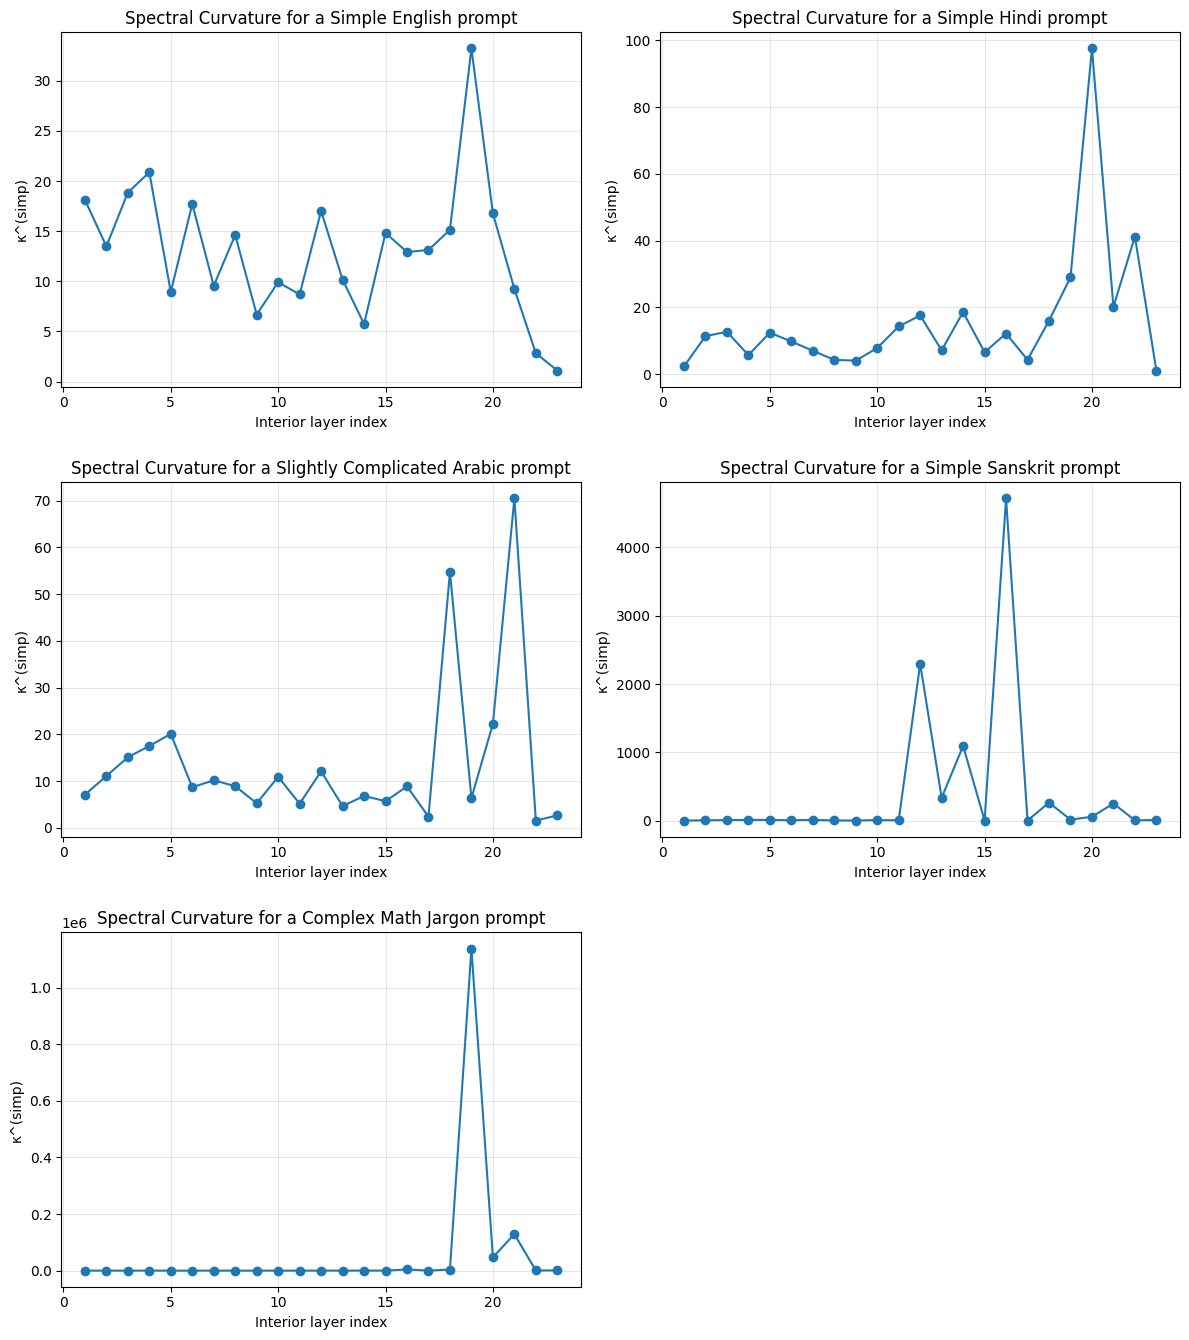

In [ ]:
# visualization

num_cols = 2
num_rows = math.ceil(len(PROMPTS) / num_cols)
plt.figure(figsize=(6 * num_cols, 4.5 * num_rows))

for idx, (name, _) in enumerate(PROMPTS, 1):
    data = results[name]["curvature"]
    m = results[name]["num_nodes"]
    xs = np.arange(1, m - 1)
    plt.subplot(num_rows, num_cols, idx)
    plt.plot(xs, data, marker='o')
    plt.title(f"Spectral Curvature for a {name} prompt")
    plt.xlabel("Interior layer index")
    plt.ylabel("κ^(simp)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Thermodynamic Length

## Libraries

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForCausalLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

## Thermodynamic Length: in terms of model parameters (initial)

In [ ]:
MODEL_NAME   = "microsoft/DialoGPT-medium"
MAX_SAMPLES  = 200
BATCH_SIZE   = 2
MAX_SEQ_LEN  = 256
NUM_WORKERS  = 2
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
SEED = 4242
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# GPU knobs
if DEVICE == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")  # PyTorch 2.x
    except Exception:
        pass

In [ ]:
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# GPT-2/DialoGPT has no pad token by default; set pad -> eos for batching
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

# Convenience aliases for GPT-2 modules
transformer   = model.transformer
blocks        = transformer.h
final_ln      = transformer.ln_f
lm_head       = model.lm_head

num_layers = len(blocks)
print(f"Model has {num_layers} decoder blocks")

Loading model: microsoft/DialoGPT-medium
Model has 24 decoder blocks


##### Datset used: SQuAD
Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 unanswerable questions written adversarially by crowdworkers to look similar to answerable ones. To do well on SQuAD2.0, systems must not only answer questions when possible, but also determine when no answer is supported by the paragraph and abstain from answering.

In [ ]:
print("Loading SQuAD (train)...")
ds = load_dataset("squad", split="train")

def build_text(example):
    q = example["question"].strip().replace("\n", " ")
    c = example["context"].strip().replace("\n", " ")
    # Prompt template — simple and consistent:
    return f"Question: {q}\nContext: {c}\nAnswer:"

ds = ds.map(lambda ex: {"text": build_text(ex)}, remove_columns=ds.column_names)

# Filter trivial/very short sequences
ds = ds.filter(lambda ex: len(ex["text"]) > 50)

if MAX_SAMPLES is not None:
    ds = ds.select(range(min(MAX_SAMPLES, len(ds))))

print(f"Dataset size after filtering/select: {len(ds)} rows")
print("\nSample prompt:")
print(ds[0]["text"][:400], " ...")

Loading SQuAD (train)...
Dataset size after filtering/select: 200 rows

Sample prompt:
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basil  ...


In [ ]:
# Collate: tokenize and build teacher-forced labels (shifted)
def causal_collate(batch):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_tensors="pt",
    )

    input_ids = tok["input_ids"]              # (B, S)
    attention_mask = tok["attention_mask"]    # (B, S)

    # Teacher forcing: predict next token
    # Shift: inputs[:-1], labels[1:]
    input_ids_shifted  = input_ids[:, :-1].contiguous()
    attention_shifted  = attention_mask[:, :-1].contiguous()
    labels_shifted     = input_ids[:, 1:].contiguous()

    # Ignore loss where the target token came from padding in the original sequence
    labels_shifted = labels_shifted.masked_fill(attention_mask[:, 1:] == 0, -100)

    batch = {
        "input_ids": input_ids_shifted,     # tokens up to second-to-last
        "labels": labels_shifted,           # next-token targets (pad -> -100)
        # We won’t use attention_mask in the blocks (causal mask handled internally),
        # but keep it for potential diagnostics:
        "attention_mask": attention_shifted,
    }
    return batch

loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=causal_collate,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [ ]:
layer_grad_sums = torch.zeros(num_layers, device=DEVICE)  # accumulate per-layer ||grad||^2
num_batches = 0

print("\nStarting per-layer effort computation (Observed Fisher style) ...")
amp_dtype = torch.bfloat16 if (DEVICE=="cuda" and torch.cuda.is_bf16_supported()) else torch.float16

for batch in tqdm(loader, total=math.ceil(len(ds)/BATCH_SIZE)):
    num_batches += 1

    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)   # (B, S-1)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)      # (B, S-1)
    B, S = input_ids.shape

    # --- Build initial embeddings
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
        h = transformer.wte(input_ids) + transformer.wpe(pos_ids)
        h = transformer.drop(h)

    # --- Per-layer losses
    per_layer_losses = []

    for ell in range(num_layers):
        h_prev = h.detach()  # <<< isolates gradients to block 'ell'

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            # Forward one block;
            h_ell = blocks[ell](h_prev)[0]

            # Logit lens at layer ell:
            logits_ell = lm_head(final_ln(h_ell))

            # Cross-entropy on teacher-forced next-token targets
            loss_ell = F.cross_entropy(
                logits_ell.view(-1, logits_ell.size(-1)),
                labels.view(-1),
                ignore_index=-100,
                reduction="mean",
            )

        per_layer_losses.append(loss_ell)
        h = h_ell  # advance the hidden state for the next block

    # --- Single backward for all ℓ ---
    model.zero_grad(set_to_none=True)
    total_loss = torch.stack(per_layer_losses).sum()
    total_loss.backward()

    # --- Accumulate squared grad norms for each block's parameters ---
    with torch.no_grad():
        for ell in range(num_layers):
            g2 = torch.tensor(0.0, device=DEVICE)
            for p in blocks[ell].parameters():
                if p.grad is not None:
                    g2 += (p.grad.detach() ** 2).sum()
            layer_grad_sums[ell] += g2


Starting per-layer effort computation (Observed Fisher style) ...


  0%|          | 0/100 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 100/100 [00:07<00:00, 13.08it/s]



--- Per-layer squared gradient norms (mean over batches) ---
Layer  1:  3.992664e+02
Layer  2:  1.469005e+02
Layer  3:  1.031729e+02
Layer  4:  6.751944e+01
Layer  5:  5.044850e+01
Layer  6:  2.885271e+01
Layer  7:  1.959129e+01
Layer  8:  1.350401e+01
Layer  9:  3.398092e+01
Layer 10:  5.492334e+01
Layer 11:  5.466752e+01
Layer 12:  4.199610e+01
Layer 13:  9.786903e+01
Layer 14:  7.590879e+01
Layer 15:  3.317836e+01
Layer 16:  3.651780e+01
Layer 17:  2.881220e+01
Layer 18:  2.992044e+01
Layer 19:  8.727541e+01
Layer 20:  6.032341e+01
Layer 21:  6.563901e+01
Layer 22:  3.131994e+01
Layer 23:  1.530174e+01
Layer 24:  5.197689e+00


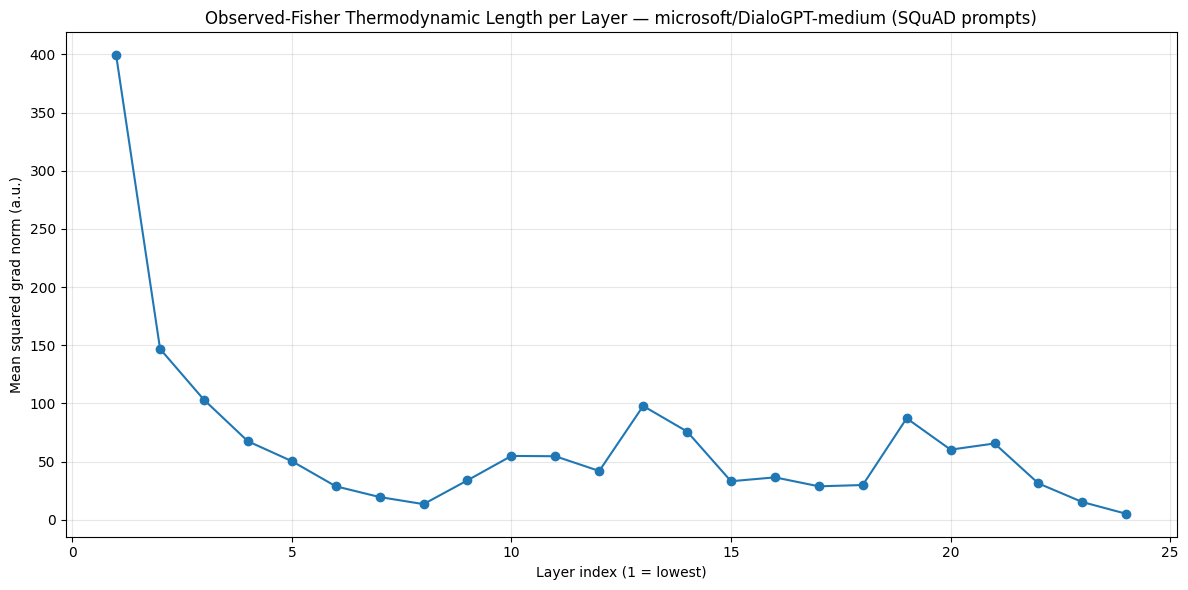

In [ ]:
#Results

layer_grad_sums_cpu = layer_grad_sums.detach().cpu().numpy()
mean_layer_grad_sq = layer_grad_sums_cpu / max(1, num_batches)  # mean over batches

print("\n--- Per-layer squared gradient norms (mean over batches) ---")
for i, val in enumerate(mean_layer_grad_sq, start=1):
    print(f"Layer {i:2d}: {val: .6e}")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(1, num_layers+1), mean_layer_grad_sq, marker='o')
plt.title(f'Observed-Fisher Thermodynamic Length per Layer — {MODEL_NAME} (SQuAD prompts)')
plt.xlabel('Layer index (1 = lowest)')
plt.ylabel('Mean squared grad norm (a.u.)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Thermodynamic Length: in terms of model predictions (revised) -- The Logit–Simplex Fisher–Rao method


Computing Thermodynamic Length from predictions (Fisher–Rao, exact) ...


  0%|          | 0/100 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 100/100 [00:03<00:00, 29.27it/s]



--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---
Between layers  1 and  2: 1.114013e+00 rad
Between layers  2 and  3: 9.349268e-01 rad
Between layers  3 and  4: 7.830060e-01 rad
Between layers  4 and  5: 8.869044e-01 rad
Between layers  5 and  6: 8.241930e-01 rad
Between layers  6 and  7: 7.426487e-01 rad
Between layers  7 and  8: 7.661605e-01 rad
Between layers  8 and  9: 1.152606e+00 rad
Between layers  9 and 10: 9.673421e-01 rad
Between layers 10 and 11: 6.738620e-01 rad
Between layers 11 and 12: 6.544952e-01 rad
Between layers 12 and 13: 8.700945e-01 rad
Between layers 13 and 14: 5.252436e-01 rad
Between layers 14 and 15: 6.041931e-01 rad
Between layers 15 and 16: 5.349993e-01 rad
Between layers 16 and 17: 5.179227e-01 rad
Between layers 17 and 18: 4.953627e-01 rad
Between layers 18 and 19: 5.017856e-01 rad
Between layers 19 and 20: 4.994848e-01 rad
Between layers 20 and 21: 4.750463e-01 rad
Between layers 21 and 22: 4.799085e-01 rad
Between layers 2

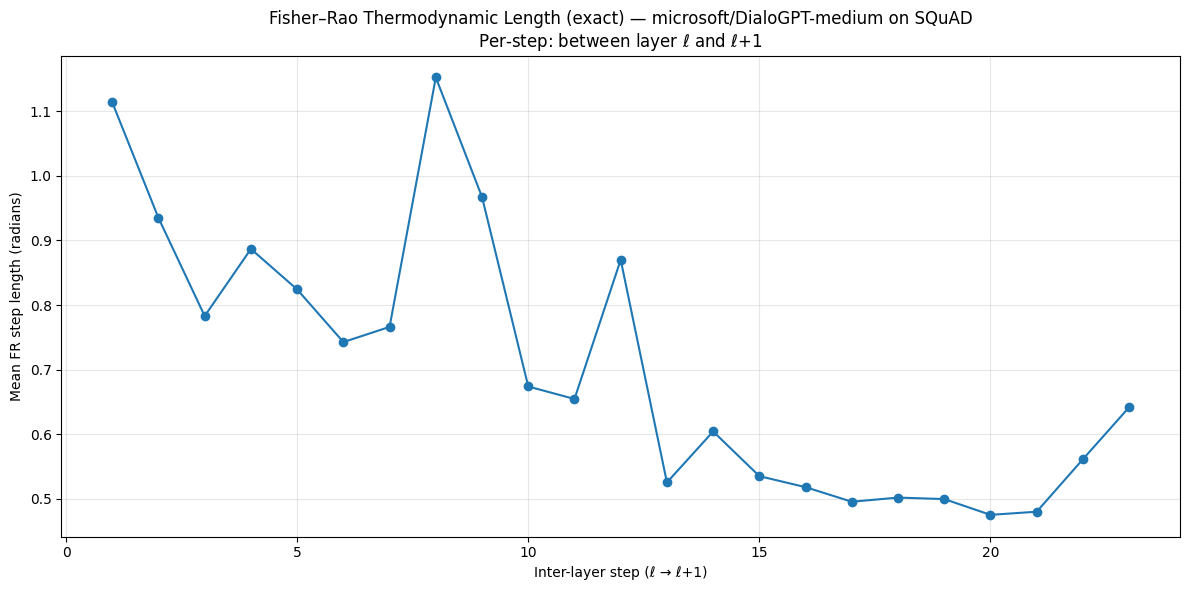

In [ ]:
# Accumulators for per-step (between layers) mean FR length
# step k corresponds to "between block k and k+1" → there are (num_layers-1) steps
num_steps = len(blocks) - 1
fr_step_sums   = torch.zeros(num_steps, device=DEVICE)  # sum of FR lengths over valid tokens
fr_step_counts = torch.zeros(num_steps, device=DEVICE)  # count of valid tokens

print("\nComputing Thermodynamic Length from predictions (Fisher–Rao, exact) ...")

@torch.no_grad()
def fr_step_from_logprobs(logp_prev, logp_next, valid_mask):

    s = 0.5 * (logp_prev + logp_next)                      # (B, S, V)
    log_bc = torch.logsumexp(s, dim=-1)                    # (B, S)
    bc = torch.exp(log_bc)                                 # (B, S), Bhattacharyya coefficient in [0, 1] (numerically may creep outside)
    bc = bc.clamp_(0.0, 1.0)
    steps = 2.0 * torch.acos(bc)                           # (B, S), exact FR step between the two distributions
    if valid_mask is not None:
        steps = steps.masked_fill(~valid_mask, 0.0)
    return steps

# Iterate over SQuAD batches again (teacher-forced)
for batch in tqdm(loader, total=math.ceil(len(loader.dataset)/loader.batch_size)):
    input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)   # (B, S-1)
    labels    = batch["labels"].to(DEVICE, non_blocking=True)      # (B, S-1)
    B, S = input_ids.shape

    # Build initial hidden state exactly as before
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
        h = transformer.wte(input_ids) + transformer.wpe(pos_ids)
        h = transformer.drop(h)

    # We will carry log-probs from the previous layer to compute FR step with the current one
    logp_prev = None

    for ell in range(len(blocks)):
        h = blocks[ell](h)[0]  # forward one block

        # "Logit lens": apply the same final LN + lm_head used at the top
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            logits = lm_head(final_ln(h))                 # (B, S, V)

        # Work in float32 for log-softmax stability
        logp = F.log_softmax(logits.float(), dim=-1)      # (B, S, V), log p^{(ℓ)}

        if logp_prev is not None:
            # Valid positions are exactly where we have a next-token target (labels != -100)
            valid = (labels != -100)                      # (B, S)

            # Exact FR step length between consecutive layers at each position t
            steps = fr_step_from_logprobs(logp_prev, logp, valid)   # (B, S)

            step_idx = ell - 1  # "between block ell-1 and ell"
            fr_step_sums[step_idx]   += steps.sum()
            fr_step_counts[step_idx] += valid.sum()

        logp_prev = logp  # slide window

# Compute mean FR length per inter-layer step
fr_step_means = (fr_step_sums / fr_step_counts.clamp_min(1)).detach().cpu().numpy()

# ----- Report -----
print("\n--- Fisher–Rao Thermodynamic Length from predictions (per inter-layer step) ---")
for k, val in enumerate(fr_step_means, start=1):
    print(f"Between layers {k:2d} and {k+1:2d}: {val:.6e} rad")

# Plot profile across depth
plt.figure(figsize=(12, 6))
x = np.arange(1, num_steps+1)
plt.plot(x, fr_step_means, marker='o')
plt.title(f'Fisher–Rao Thermodynamic Length (exact) — {MODEL_NAME} on SQuAD\n'
          f'Per-step: between layer $\\ell$ and $\\ell{{+}}1$')
plt.xlabel('Inter-layer step (ℓ → ℓ+1)')
plt.ylabel('Mean FR step length (radians)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Merge: The Semantic Efficiency

Data successfully aligned. Using parameter strain from layers 1 to 23.
Original Parameter Strain data length: 24
Matched Parameter Strain data length: 23
Belief Change data length: 23

--- Final Metrics ---
Layer |   Param Strain (E_l) |   Belief Change (Δp_l) |  Semantic Efficiency (L_eff)
-------------------------------------------------------------------------------------
    1 |           3.9924e+02 |           1.114033e+00 |                       0.6643
    2 |           1.4689e+02 |           9.349279e-01 |                       1.0861
    3 |           1.0319e+02 |           7.830067e-01 |                       1.0834
    4 |           6.7530e+01 |           8.869028e-01 |                       1.6753
    5 |           5.0453e+01 |           8.242082e-01 |                       1.8532
    6 |           2.8857e+01 |           7.426243e-01 |                       2.3909
    7 |           1.9598e+01 |           7.661914e-01 |                       3.3398
    8 |           1.3507e+0

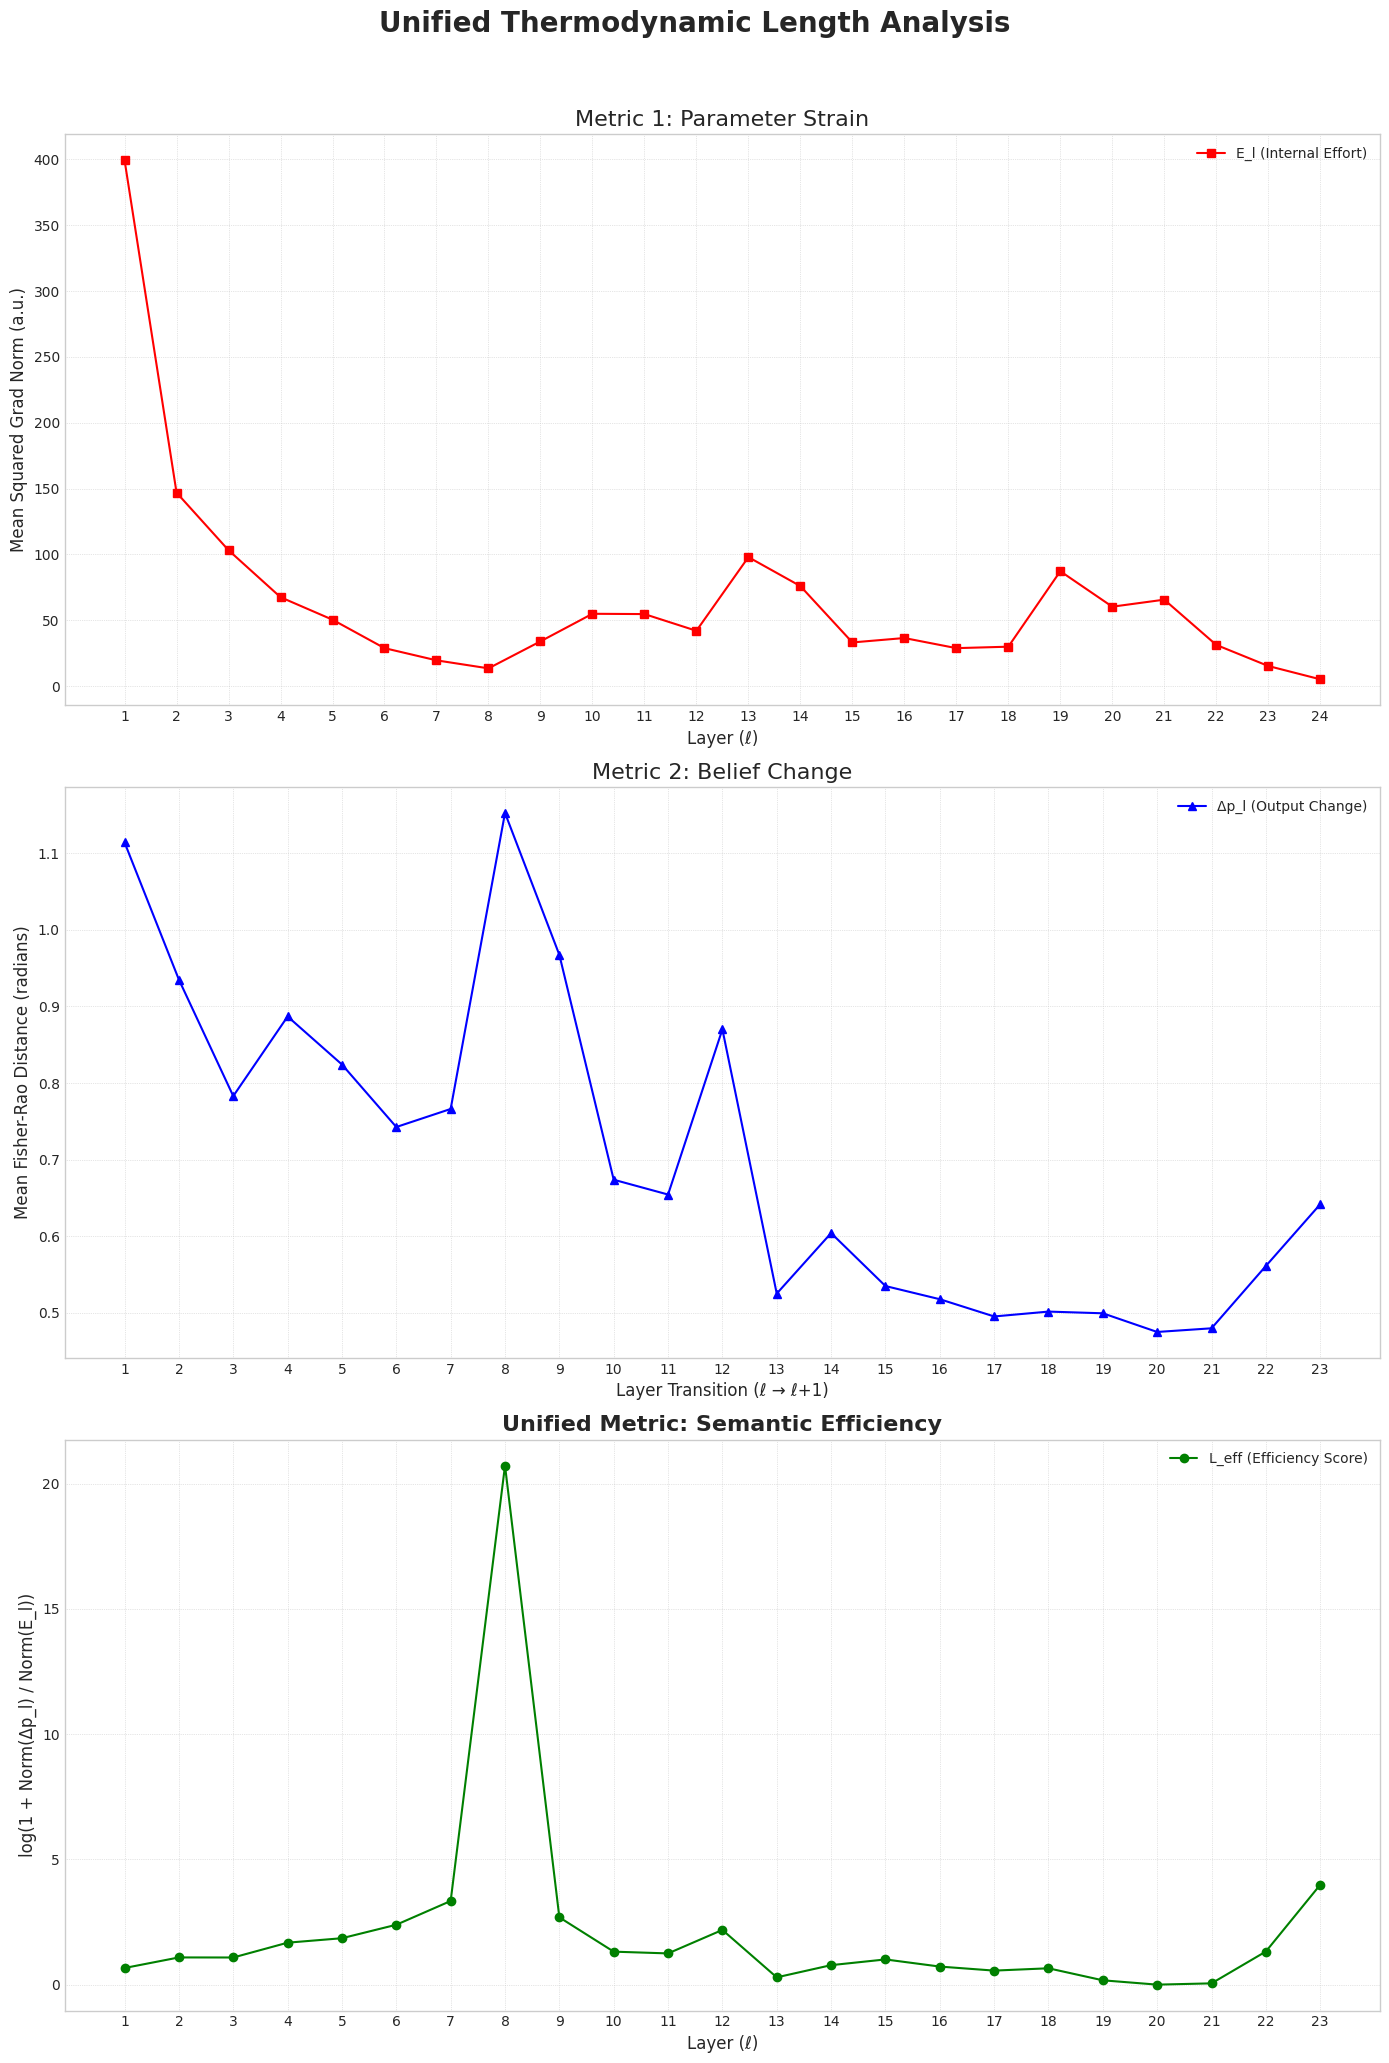

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Data for Δp_l: Fisher-Rao distance between consecutive layers (23 values)
raw_belief_change = np.array([
    1.114033e+00, 9.349279e-01, 7.830067e-01, 8.869028e-01, 8.242082e-01,
    7.426243e-01, 7.661914e-01, 1.152593e+00, 9.673551e-01, 6.738328e-01,
    6.544784e-01, 8.701219e-01, 5.251812e-01, 6.041710e-01, 5.350522e-01,
    5.178429e-01, 4.953289e-01, 5.016868e-01, 4.994725e-01, 4.750937e-01,
    4.798741e-01, 5.612271e-01, 6.417844e-01
])

# Data for E_l: Mean squared gradient norm at each layer (24 values)
raw_param_strain = np.array([
    3.992427e+02, 1.468945e+02, 1.031877e+02, 6.752973e+01, 5.045254e+01,
    2.885660e+01, 1.959774e+01, 1.350743e+01, 3.399373e+01, 5.494263e+01,
    5.472042e+01, 4.202975e+01, 9.795194e+01, 7.596672e+01, 3.318478e+01,
    3.653396e+01, 2.885680e+01, 2.995477e+01, 8.726003e+01, 6.032204e+01,
    6.566399e+01, 3.132142e+01, 1.530250e+01, 5.202253e+00
])

EPSILON = 1e-9 # Small constant for numerical stability

# Handle Mismatched Array Sizes

param_strain_matched = raw_param_strain[:23]

print("Data successfully aligned. Using parameter strain from layers 1 to 23.")
print(f"Original Parameter Strain data length: {len(raw_param_strain)}")
print(f"Matched Parameter Strain data length: {len(param_strain_matched)}")
print(f"Belief Change data length: {len(raw_belief_change)}")


# Normalize Both Metrics to a [0, 1] Range

def min_max_scale(x):
    """Scales a numpy array to the [0, 1] range."""
    return (x - x.min()) / (x.max() - x.min() + EPSILON)

norm_param_strain = min_max_scale(param_strain_matched)
norm_belief_change = min_max_scale(raw_belief_change)

# Calculate the Final "Semantic Efficiency"
# Formula: L_eff(l) = log(1 + Δp_l_norm / (E_l_norm + ε))
semantic_efficiency = np.log(1 + norm_belief_change / (norm_param_strain + EPSILON))


# Report and Plot
print("\n--- Final Metrics ---")
print(f"{'Layer':>5} | {'Param Strain (E_l)':>20} | {'Belief Change (Δp_l)':>22} | {'Semantic Efficiency (L_eff)':>28}")
print("-" * 85)
for i in range(len(semantic_efficiency)):
    print(f"{i+1:>5} | {param_strain_matched[i]:>20.4e} | {raw_belief_change[i]:>22.6e} | {semantic_efficiency[i]:>28.4f}")

# Create a comprehensive 3-panel plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 21), sharex=False)
fig.suptitle('Unified Thermodynamic Length Analysis', fontsize=20, fontweight='bold')

# --- Plot 1: Parameter Strain (E_l) ---
layer_indices_strain = range(1, len(raw_param_strain) + 1)
axes[0].plot(layer_indices_strain, raw_param_strain, marker='s', color='red', label='E_l (Internal Effort)')
axes[0].set_title('Metric 1: Parameter Strain', fontsize=16)
axes[0].set_ylabel('Mean Squared Grad Norm (a.u.)', fontsize=12)
axes[0].set_xlabel('Layer (ℓ)', fontsize=12)
axes[0].set_xticks(layer_indices_strain)
axes[0].legend()
axes[0].grid(True, which='both', linestyle=':', linewidth=0.5)

# --- Plot 2: Belief Change (Δp_l) ---
layer_indices_change = range(1, len(raw_belief_change) + 1)
axes[1].plot(layer_indices_change, raw_belief_change, marker='^', color='blue', label='Δp_l (Output Change)')
axes[1].set_title('Metric 2: Belief Change', fontsize=16)
axes[1].set_ylabel('Mean Fisher-Rao Distance (radians)', fontsize=12)
axes[1].set_xlabel('Layer Transition (ℓ → ℓ+1)', fontsize=12)
axes[1].set_xticks(layer_indices_change)
axes[1].legend()
axes[1].grid(True, which='both', linestyle=':', linewidth=0.5)

# --- Plot 3: Semantic Efficiency (L_eff) ---
layer_indices_eff = range(1, len(semantic_efficiency) + 1)
axes[2].plot(layer_indices_eff, semantic_efficiency, marker='o', color='green', label='L_eff (Efficiency Score)')
axes[2].set_title('Unified Metric: Semantic Efficiency', fontsize=16, fontweight='bold')
axes[2].set_ylabel('log(1 + Norm(Δp_l) / Norm(E_l))', fontsize=12)
axes[2].set_xlabel('Layer (ℓ)', fontsize=12)
axes[2].set_xticks(layer_indices_eff)
axes[2].legend()
axes[2].grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Belief Vector Fields

## DialoGPT

##### Import

In [ ]:
# %% [markdown]
# # Belief Vector Fields on the Logit–Simplex (Method 5) for Three Concepts
# - Model: DialoGPT-medium (GPT-2 family, decoder-only)
# - Concepts: AG News (World, Sports, Sci/Tech)
# - Output: Layer-wise norms of belief vector fields v_ell(concept), three colored lines

# %% [code]
!pip -q install transformers datasets accelerate torch --upgrade

# %% [code]
import math, random, os
import numpy as np
from functools import partial
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


##### initialisation

In [ ]:
MODEL_NAME              = "microsoft/DialoGPT-medium"
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
SEED                    = 1337

MAX_SEQ_LEN             = 128           # keep moderate to control memory
BATCH_SIZE              = 1             # larger works, but this is safest for V~50k
MAX_SAMPLES_PER_CONCEPT = 150           # per concept; raise for smoother curves
TOKENS_PER_EX           = 32            # per example: keep last K supervised steps
TAU                     = 1.0           # temperature in the softmax for q_ell
FR_NORM                 = True          # if True, report 2*||v|| (FR norm); else ||v|| Euclidean
AMP_DTYPE               = (torch.bfloat16
                           if (DEVICE=="cuda" and torch.cuda.is_bf16_supported())
                           else torch.float16)

print(f"Device: {DEVICE}  |  AMP dtype: {AMP_DTYPE}  |  FR_NORM={FR_NORM}")

Device: cuda  |  AMP dtype: torch.bfloat16  |  FR_NORM=True


In [ ]:
# Repro
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

transformer = model.transformer       # GPT2Model
blocks      = transformer.h           # list of decoder blocks
final_ln    = transformer.ln_f        # final LayerNorm (used by top head)
lm_head     = model.lm_head           # tied unembedding
num_layers  = len(blocks)
vocab_size  = model.config.vocab_size

print(f"Layers: {num_layers}  |  Vocab: {vocab_size}")

Layers: 24  |  Vocab: 50257


##### Dataset: AG News

In [ ]:
# Concepts from AG News
# Labels: 0=World, 1=Sports, 2=Business, 3=Sci/Tech
# We'll take three contrasting concepts: World, Sports, Sci/Tech
# ----------------------------
def build_text_agnews(example):

    return example["text"].strip()

ag = load_dataset("ag_news")  # splits: train/test

def make_concept_split(ds, label_id, max_samples):
    sub = ds.filter(lambda ex: ex["label"] == label_id)
    if max_samples is not None:
        sub = sub.select(range(min(max_samples, len(sub))))
    return sub.map(lambda ex: {"text": build_text_agnews(ex)}, remove_columns=sub.column_names)

concept_specs = [
    ("World",   0),
    ("Sports",  1),
    ("Sci/Tech",3),
]

concept_datasets = {
    name: make_concept_split(ag["train"], lbl, MAX_SAMPLES_PER_CONCEPT)
    for (name, lbl) in concept_specs
}

for k, v in concept_datasets.items():
    print(f"{k:8s}: {len(v)} samples")

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

World   : 150 samples
Sports  : 150 samples
Sci/Tech: 150 samples


In [ ]:
def causal_collate_keep_last_k(batch, tokenizer, max_len, keep_last_k):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts, padding="longest", truncation=True,
        max_length=max_len, return_tensors="pt"
    )
    input_ids = tok["input_ids"]            # (B,S)
    attn_mask = tok["attention_mask"]       # (B,S)

    # shift for next-token prediction
    x   = input_ids[:, :-1].contiguous()
    y   = input_ids[:,  1:].contiguous()
    msk = attn_mask[:, 1:].contiguous()

    # ignore padding
    y = y.masked_fill(msk == 0, -100)

    # Now per-sample, keep only last K supervised positions (where y != -100)
    B, S1 = x.shape
    sel_mask = torch.zeros_like(y, dtype=torch.bool)
    for b in range(B):
        valid = (y[b] != -100).nonzero(as_tuple=False).squeeze(-1)
        if valid.numel() > 0:
            take = valid[-min(keep_last_k, valid.numel()):]
            sel_mask[b, take] = True

    # We'll carry the full x to produce corresponding hidden states,
    # but only use positions where sel_mask==True to build belief vectors.
    return {
        "input_ids": x,
        "labels": y,
        "select_mask": sel_mask,   # (B,S-1) booleans, True for positions we keep
    }

collate_fn = partial(causal_collate_keep_last_k, tokenizer=tokenizer,
                     max_len=MAX_SEQ_LEN, keep_last_k=TOKENS_PER_EX)

##### Function for Core Computation

In [ ]:
# Core computation

@torch.no_grad()
def belief_field_for_concept(ds, concept_name):
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    # Accumulators: per-layer sums over selected positions
    v_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    u_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    cnt   = [0 for _ in range(num_layers)]

    for batch in tqdm(loader, desc=f"[{concept_name}]"):
        x      = batch["input_ids"].to(DEVICE)     # (B,S)
        y      = batch["labels"].to(DEVICE)        # (B,S)
        keep_m = batch["select_mask"].to(DEVICE)   # (B,S)

        B, S = x.shape

        # Build embeddings like GPT-2 forward: wte + wpe + drop
        with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                            dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
            pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
            h = transformer.wte(x) + transformer.wpe(pos_ids)
            h = transformer.drop(h)

        # Sequentially traverse layers
        for ell in range(num_layers):
            with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                                dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
                h = blocks[ell](h)[0]                 # (B,S,d)
                z = lm_head(final_ln(h))              # (B,S,V) logits at layer ell

            # flatten to (B*S, V), but keep only selected positions
            keep = keep_m.view(-1)                   # (B*S,)
            if keep.any():
                z_sel = z.view(-1, z.size(-1))[keep]          # (N_sel, V) half precision
                y_sel = y.view(-1)[keep]                       # (N_sel,)

                # Compute q,u in float32 for stability
                z32 = z_sel.float() / TAU
                q   = F.softmax(z32, dim=-1)                   # (N_sel, V)
                q = torch.clamp(q, min=1e-12)                  # stabilize
                u   = torch.sqrt(q)                            # (N_sel, V)

                # Build g = (1/tau)(e_y - q) without one-hot
                g = -q / TAU                                   # (N_sel, V)
                # add +1/tau at the target indices
                add = torch.full((y_sel.shape[0], 1), 1.0/TAU, device=DEVICE, dtype=q.dtype)
                g.scatter_add_(dim=-1, index=y_sel.unsqueeze(-1), src=add)

                # Compute t = (1/(2*tau)) * [ u*g - ( (q*g).sum(-1) * u ) ]
                ug = u * g                                     # (N_sel, V)
                s  = (q * g).sum(dim=-1, keepdim=True)         # (N_sel, 1)
                t  = (ug - s * u) / (2.0 * TAU)                # (N_sel, V)

                # Accumulate sums over selected positions
                v_sum[ell] += t.sum(dim=0).to(v_sum[ell].dtype)  # (V,)
                u_sum[ell] += u.sum(dim=0).to(u_sum[ell].dtype)  # (V,)
                cnt[ell]   += t.size(0)

    # Finalize per-layer vectors: average, rebase to mean u, measure norm
    norms = []
    for ell in range(num_layers):
        if cnt[ell] == 0:
            norms.append(0.0)
            continue
        v_avg = (v_sum[ell] / cnt[ell])       # (V,)
        u_avg = (u_sum[ell] / cnt[ell])       # (V,)
        # normalize u_avg to unit sphere (anchor base point)
        u_norm = torch.linalg.norm(u_avg).clamp_min(1e-12)
        u_bar  = u_avg / u_norm
        # project v_avg into tangent at u_bar: remove radial component
        radial = torch.dot(u_bar, v_avg)
        v_tan  = v_avg - radial * u_bar
        # report FR norm (2*||·||) or Euclidean norm
        n = 2.0 * torch.linalg.norm(v_tan).item() if FR_NORM else torch.linalg.norm(v_tan).item()
        norms.append(n)
    return np.array(norms, dtype=float)


##### Run and Plots

[Sci/Tech]: 100%|██████████| 150/150 [00:03<00:00, 40.86it/s]


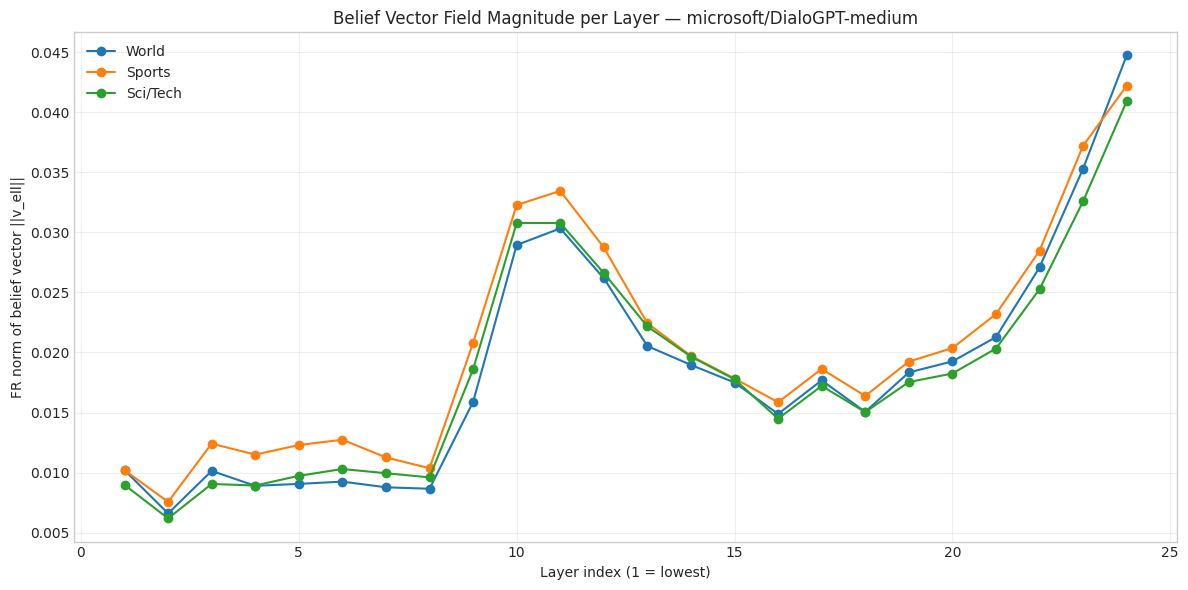

In [ ]:
concept_curves = {}
for name, _ in concept_specs:
    norms = belief_field_for_concept(concept_datasets[name], name)
    concept_curves[name] = norms

plt.figure(figsize=(12,6))
layers = np.arange(1, num_layers+1)
colors = {"World":"tab:blue", "Sports":"tab:orange", "Sci/Tech":"tab:green"}

for name in concept_curves:
    plt.plot(layers, concept_curves[name], marker='o', label=name, color=colors.get(name,None))

ylabel = "FR norm of belief vector ||v_ell||" if FR_NORM else "Euclidean norm of belief vector ||v_ell||"
plt.title(f"Belief Vector Field Magnitude per Layer — {MODEL_NAME}")
plt.xlabel("Layer index (1 = lowest)")
plt.ylabel(ylabel)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## GPT-2

##### Import

In [ ]:
# %% [markdown]
# # Belief Vector Fields on the Logit–Simplex (Method 5) for Three Concepts
# - Model: DialoGPT-medium (GPT-2 family, decoder-only)
# - Concepts: AG News (World, Sports, Sci/Tech)
# - Output: Layer-wise norms of belief vector fields v_ell(concept), three colored lines

# %% [code]
!pip -q install transformers datasets accelerate torch --upgrade

# %% [code]
import math, random, os
import numpy as np
from functools import partial
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


##### initialisation

In [ ]:
MODEL_NAME              = "gpt2"
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
SEED                    = 1337
MAX_SEQ_LEN             = 128           # keep moderate to control memory
BATCH_SIZE              = 1             # larger works, but this is safest for V~50k
MAX_SAMPLES_PER_CONCEPT = 150           # per concept; raise for smoother curves
TOKENS_PER_EX          = 32            # per example: keep last K supervised steps
TAU                     = 1.0           # temperature in the softmax for q_ell
FR_NORM                 = True          # if True, report 2*||v|| (FR norm); else ||v|| Euclidean
AMP_DTYPE               = (torch.bfloat16
                           if (DEVICE=="cuda" and torch.cuda.is_bf16_supported())
                           else torch.float16)

print(f"Device: {DEVICE}  |  AMP dtype: {AMP_DTYPE}  |  FR_NORM={FR_NORM}")

Device: cuda  |  AMP dtype: torch.bfloat16  |  FR_NORM=True


In [ ]:
# Repro
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

transformer = model.transformer       # GPT2Model
blocks      = transformer.h           # list of decoder blocks
final_ln    = transformer.ln_f        # final LayerNorm (used by top head)
lm_head     = model.lm_head           # tied unembedding
num_layers  = len(blocks)
vocab_size  = model.config.vocab_size

print(f"Layers: {num_layers}  |  Vocab: {vocab_size}")

Layers: 12  |  Vocab: 50257


##### Dataset: AG News

In [ ]:
# Concepts from AG News
# Labels: 0=World, 1=Sports, 2=Business, 3=Sci/Tech
# We'll take three contrasting concepts: World, Sports, Sci/Tech
# ----------------------------
def build_text_agnews(example):

    return example["text"].strip()

ag = load_dataset("ag_news")  # splits: train/test

def make_concept_split(ds, label_id, max_samples):
    sub = ds.filter(lambda ex: ex["label"] == label_id)
    if max_samples is not None:
        sub = sub.select(range(min(max_samples, len(sub))))
    return sub.map(lambda ex: {"text": build_text_agnews(ex)}, remove_columns=sub.column_names)

concept_specs = [
    ("World",   0),
    ("Sports",  1),
    ("Sci/Tech",3),
]

concept_datasets = {
    name: make_concept_split(ag["train"], lbl, MAX_SAMPLES_PER_CONCEPT)
    for (name, lbl) in concept_specs
}

for k, v in concept_datasets.items():
    print(f"{k:8s}: {len(v)} samples")

World   : 150 samples
Sports  : 150 samples
Sci/Tech: 150 samples


In [ ]:
def causal_collate_keep_last_k(batch, tokenizer, max_len, keep_last_k):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts, padding="longest", truncation=True,
        max_length=max_len, return_tensors="pt"
    )
    input_ids = tok["input_ids"]            # (B,S)
    attn_mask = tok["attention_mask"]       # (B,S)

    # shift for next-token prediction
    x   = input_ids[:, :-1].contiguous()
    y   = input_ids[:,  1:].contiguous()
    msk = attn_mask[:, 1:].contiguous()

    # ignore padding
    y = y.masked_fill(msk == 0, -100)

    # Now per-sample, keep only last K supervised positions (where y != -100)
    B, S1 = x.shape
    sel_mask = torch.zeros_like(y, dtype=torch.bool)
    for b in range(B):
        valid = (y[b] != -100).nonzero(as_tuple=False).squeeze(-1)
        if valid.numel() > 0:
            take = valid[-min(keep_last_k, valid.numel()):]
            sel_mask[b, take] = True

    # We'll carry the full x to produce corresponding hidden states,
    # but only use positions where sel_mask==True to build belief vectors.
    return {
        "input_ids": x,
        "labels": y,
        "select_mask": sel_mask,   # (B,S-1) booleans, True for positions we keep
    }

collate_fn = partial(causal_collate_keep_last_k, tokenizer=tokenizer,
                     max_len=MAX_SEQ_LEN, keep_last_k=TOKENS_PER_EX)

##### Function for Core Computation

In [ ]:
# Core computation

@torch.no_grad()
def belief_field_for_concept(ds, concept_name):
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    # Accumulators: per-layer sums over selected positions
    v_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    u_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    cnt   = [0 for _ in range(num_layers)]

    for batch in tqdm(loader, desc=f"[{concept_name}]"):
        x      = batch["input_ids"].to(DEVICE)     # (B,S)
        y      = batch["labels"].to(DEVICE)        # (B,S)
        keep_m = batch["select_mask"].to(DEVICE)   # (B,S)

        B, S = x.shape

        # Build embeddings like GPT-2 forward: wte + wpe + drop
        with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                            dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
            pos_ids = torch.arange(S, dtype=torch.long, device=DEVICE).unsqueeze(0).expand(B, S)
            h = transformer.wte(x) + transformer.wpe(pos_ids)
            h = transformer.drop(h)

        # Sequentially traverse layers
        for ell in range(num_layers):
            with torch.autocast(device_type=("cuda" if DEVICE=="cuda" else "cpu"),
                                dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")):
                h = blocks[ell](h)[0]                 # (B,S,d)
                z = lm_head(final_ln(h))              # (B,S,V) logits at layer ell

            # flatten to (B*S, V), but keep only selected positions
            keep = keep_m.view(-1)                   # (B*S,)
            if keep.any():
                z_sel = z.view(-1, z.size(-1))[keep]          # (N_sel, V) half precision
                y_sel = y.view(-1)[keep]                       # (N_sel,)

                # Compute q,u in float32 for stability
                z32 = z_sel.float() / TAU
                q   = F.softmax(z32, dim=-1)                   # (N_sel, V)
                q = torch.clamp(q, min=1e-12)                  # stabilize
                u   = torch.sqrt(q)                            # (N_sel, V)

                # Build g = (1/tau)(e_y - q) without one-hot
                g = -q / TAU                                   # (N_sel, V)
                # add +1/tau at the target indices
                add = torch.full((y_sel.shape[0], 1), 1.0/TAU, device=DEVICE, dtype=q.dtype)
                g.scatter_add_(dim=-1, index=y_sel.unsqueeze(-1), src=add)

                # Compute t = (1/(2*tau)) * [ u*g - ( (q*g).sum(-1) * u ) ]
                ug = u * g                                     # (N_sel, V)
                s  = (q * g).sum(dim=-1, keepdim=True)         # (N_sel, 1)
                t  = (ug - s * u) / (2.0 * TAU)                # (N_sel, V)

                # Accumulate sums over selected positions
                v_sum[ell] += t.sum(dim=0).to(v_sum[ell].dtype)  # (V,)
                u_sum[ell] += u.sum(dim=0).to(u_sum[ell].dtype)  # (V,)
                cnt[ell]   += t.size(0)

            # else: no selected positions; just continue

    # Finalize per-layer vectors: average, rebase to mean u, measure norm
    norms = []
    for ell in range(num_layers):
        if cnt[ell] == 0:
            norms.append(0.0)
            continue
        v_avg = (v_sum[ell] / cnt[ell])       # (V,)
        u_avg = (u_sum[ell] / cnt[ell])       # (V,)
        # normalize u_avg to unit sphere (anchor base point)
        u_norm = torch.linalg.norm(u_avg).clamp_min(1e-12)
        u_bar  = u_avg / u_norm
        # project v_avg into tangent at u_bar: remove radial component
        radial = torch.dot(u_bar, v_avg)
        v_tan  = v_avg - radial * u_bar
        # report FR norm (2*||·||) or Euclidean norm
        n = 2.0 * torch.linalg.norm(v_tan).item() if FR_NORM else torch.linalg.norm(v_tan).item()
        norms.append(n)
    return np.array(norms, dtype=float)

##### Run and Plots

[Sci/Tech]: 100%|██████████| 150/150 [00:01<00:00, 79.97it/s]


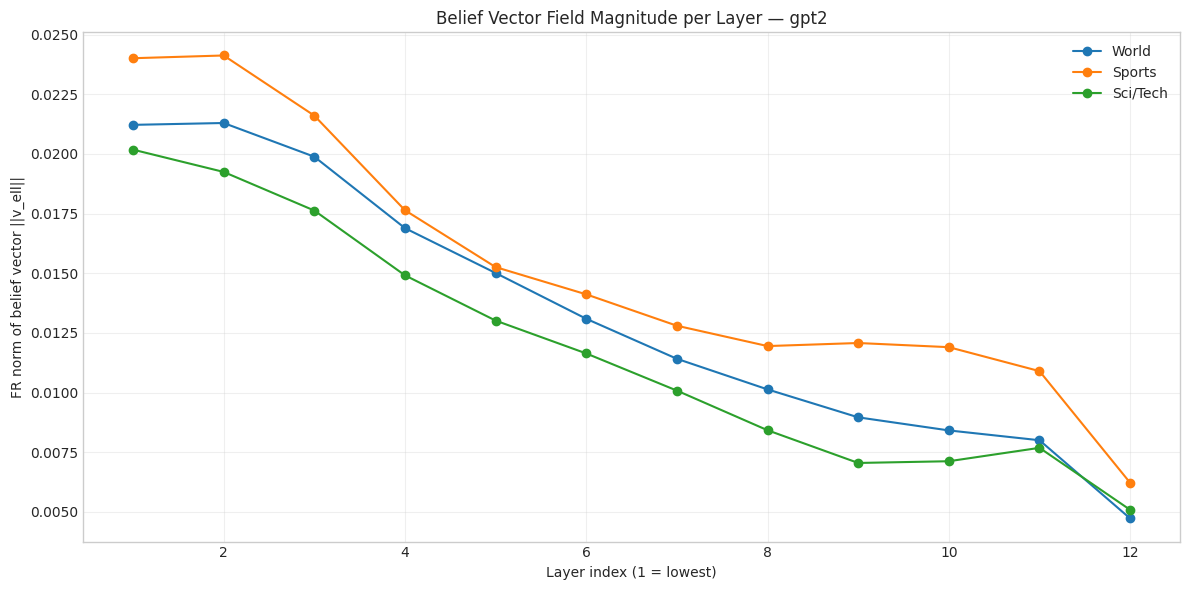

In [ ]:
concept_curves = {}
for name, _ in concept_specs:
    norms = belief_field_for_concept(concept_datasets[name], name)
    concept_curves[name] = norms

plt.figure(figsize=(12,6))
layers = np.arange(1, num_layers+1)
colors = {"World":"tab:blue", "Sports":"tab:orange", "Sci/Tech":"tab:green"}

for name in concept_curves:
    plt.plot(layers, concept_curves[name], marker='o', label=name, color=colors.get(name,None))

ylabel = "FR norm of belief vector ||v_ell||" if FR_NORM else "Euclidean norm of belief vector ||v_ell||"
plt.title(f"Belief Vector Field Magnitude per Layer — {MODEL_NAME}")
plt.xlabel("Layer index (1 = lowest)")
plt.ylabel(ylabel)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## TInyLlama - 1.1B


##### Import


In [ ]:
# %% [markdown]
# # Belief Vector Fields on the Logit–Simplex (Method 5) for Three Concepts
# - Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0 (LLaMA family, decoder-only)
# - Concepts: AG News (World, Sports, Sci/Tech)
# - Output: Layer-wise norms of belief vector fields v_ell(concept), three colored lines

# %% [code]
!pip -q install --upgrade transformers datasets accelerate torch

# %% [code]
import math, random, os
import numpy as np
from functools import partial
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


##### initialisation

In [ ]:
MODEL_NAME              = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
SEED                    = 1337

MAX_SEQ_LEN             = 128           # modest length to control memory
BATCH_SIZE              = 1             # safe for large vocab
MAX_SAMPLES_PER_CONCEPT = 150           # per concept; increase for smoother curves
TOKENS_PER_EX           = 32            # keep last K supervised positions
TAU                     = 1.0           # softmax temperature for q
FR_NORM                 = True          # if True, report Fisher-Rao norm (2*||v||); else Euclidean ||v||
AMP_DTYPE               = (torch.bfloat16
                           if (DEVICE=="cuda" and torch.cuda.is_bf16_supported())
                           else torch.float16)

print(f"Device: {DEVICE}  |  AMP dtype: {AMP_DTYPE}  |  FR_NORM={FR_NORM}")

Device: cuda  |  AMP dtype: torch.bfloat16  |  FR_NORM=True


In [ ]:
# Repro & perf knobs
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)
# speed/memory: no KV cache needed since we do full-seq forward once
if hasattr(model.config, "use_cache"):
    model.config.use_cache = False

# LLaMA components
llama_model = model.model               # LlamaModel
blocks      = llama_model.layers        # list of LlamaDecoderLayer
final_norm  = llama_model.norm          # final RMSNorm before lm_head
lm_head     = model.lm_head
num_layers  = len(blocks)
vocab_size  = model.config.vocab_size
print(f"Layers: {num_layers}  |  Vocab: {vocab_size}")

Layers: 22  |  Vocab: 32000


##### Dataset: AG News

In [ ]:
def build_text_agnews(example):
    return example["text"].strip()

ag = load_dataset("ag_news")  # splits: train/test

def make_concept_split(ds, label_id, max_samples):
    sub = ds.filter(lambda ex: ex["label"] == label_id)
    if max_samples is not None:
        sub = sub.select(range(min(max_samples, len(sub))))
    return sub.map(lambda ex: {"text": build_text_agnews(ex)}, remove_columns=sub.column_names)

concept_specs = [
    ("World",   0),
    ("Sports",  1),
    ("Sci/Tech",3),
]

concept_datasets = {
    name: make_concept_split(ag["train"], lbl, MAX_SAMPLES_PER_CONCEPT)
    for (name, lbl) in concept_specs
}

for k, v in concept_datasets.items():
    print(f"{k:8s}: {len(v)} samples")

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

World   : 150 samples
Sports  : 150 samples
Sci/Tech: 150 samples


##### Function for Core Computation

In [ ]:
def causal_collate_keep_last_k(batch, tokenizer, max_len, keep_last_k):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts, padding="longest", truncation=True,
        max_length=max_len, return_tensors="pt"
    )
    input_ids = tok["input_ids"]            # (B, S)
    attn_mask = tok["attention_mask"]       # (B, S)

    # teacher-forced shift
    x        = input_ids[:, :-1].contiguous()          # (B, S-1)
    y        = input_ids[:,  1:].contiguous()          # (B, S-1)
    attn_x   = attn_mask[:, :-1].contiguous()          # (B, S-1)
    attn_y   = attn_mask[:,  1:].contiguous()          # (B, S-1)

    # ignore padding in labels
    y = y.masked_fill(attn_y == 0, -100)

    # per-sample: keep only last K supervised positions (y != -100)
    B, S1 = x.shape
    sel_mask = torch.zeros_like(y, dtype=torch.bool)
    for b in range(B):
        valid = (y[b] != -100).nonzero(as_tuple=False).squeeze(-1)
        if valid.numel() > 0:
            take = valid[-min(keep_last_k, valid.numel()):]
            sel_mask[b, take] = True

    return {
        "input_ids": x,          # (B, S-1)
        "attention_mask": attn_x,# (B, S-1) important for LLaMA to mask pads
        "labels": y,             # (B, S-1)
        "select_mask": sel_mask, # (B, S-1) booleans for positions we keep
    }

collate_fn = partial(causal_collate_keep_last_k, tokenizer=tokenizer,
                     max_len=MAX_SEQ_LEN, keep_last_k=TOKENS_PER_EX)

In [ ]:
@torch.no_grad()
def belief_field_for_concept(ds, concept_name):
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

    v_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    u_sum = [torch.zeros(vocab_size, device=DEVICE, dtype=torch.float32) for _ in range(num_layers)]
    cnt   = [0 for _ in range(num_layers)]

    autocast_kwargs = dict(
        device_type=("cuda" if DEVICE=="cuda" else "cpu"),
        dtype=AMP_DTYPE, enabled=(DEVICE=="cuda")
    )

    for batch in tqdm(loader, desc=f"[{concept_name}]"):
        x       = batch["input_ids"].to(DEVICE)       # (B, S)
        attn    = batch["attention_mask"].to(DEVICE)  # (B, S)
        y       = batch["labels"].to(DEVICE)          # (B, S)
        keep_m  = batch["select_mask"].to(DEVICE)     # (B, S)
        B, S    = x.shape

        # Single forward to get ALL layer hidden states (LLaMA-friendly)
        with torch.autocast(**autocast_kwargs):
            outputs = model(
                input_ids=x,
                attention_mask=attn,
                use_cache=False,
                output_hidden_states=True,
            )
            # outputs.hidden_states: tuple of length (num_layers + 1), including embeddings at index 0
            hidden_states = outputs.hidden_states  # tuple[ (B,S,d) ... ]

        # For each layer ell, get its post-layer hidden state = hidden_states[ell+1]
        for ell in range(num_layers):
            with torch.autocast(**autocast_kwargs):
                h_ell = hidden_states[ell + 1]          # (B, S, d)
                z     = lm_head(final_norm(h_ell))      # logit lens at layer ell: (B, S, V)

            # keep only selected positions for supervised steps
            keep = keep_m.view(-1)                      # (B*S,)
            if not keep.any():
                continue

            z_sel = z.view(-1, z.size(-1))[keep]       # (N_sel, V)
            y_sel = y.view(-1)[keep]                   # (N_sel,)

            # q,u in float32 for numerical stability
            z32 = (z_sel.float() / TAU)
            q   = F.softmax(z32, dim=-1)               # (N_sel, V)
            q   = torch.clamp(q, min=1e-12)
            u   = torch.sqrt(q)                        # (N_sel, V)

            # g = (1/τ)(e_y - q) without building one-hot explicitly
            g = -q / TAU                               # start with -q/τ
            add = torch.full((y_sel.shape[0], 1), 1.0/TAU, device=DEVICE, dtype=q.dtype)
            g.scatter_add_(dim=-1, index=y_sel.unsqueeze(-1), src=add)

            # t = (1/(2τ)) * [Diag(u)g - u (q^T g)] ; implement as (ug - s*u)/(2τ)
            ug = u * g                                  # (N_sel, V)
            s  = (q * g).sum(dim=-1, keepdim=True)      # (N_sel, 1)
            t  = (ug - s * u) / (2.0 * TAU)             # (N_sel, V)  -- already tangent

            # Accumulate across selected positions
            v_sum[ell] += t.sum(dim=0).to(v_sum[ell].dtype)  # (V,)
            u_sum[ell] += u.sum(dim=0).to(u_sum[ell].dtype)  # (V,)
            cnt[ell]   += t.size(0)

    # Finalize per-layer vectors: average, anchor at mean u, project, take norm
    norms = []
    for ell in range(num_layers):
        if cnt[ell] == 0:
            norms.append(0.0)
            continue
        v_avg = (v_sum[ell] / cnt[ell])       # (V,)
        u_avg = (u_sum[ell] / cnt[ell])       # (V,)

        # anchor: normalize u_avg to the sphere
        u_norm = torch.linalg.norm(u_avg).clamp_min(1e-12)
        u_bar  = u_avg / u_norm

        # project v_avg into tangent at u_bar (remove any residual radial part)
        radial = torch.dot(u_bar, v_avg)
        v_tan  = v_avg - radial * u_bar

        n = torch.linalg.norm(v_tan).item()
        norms.append(2.0 * n if FR_NORM else n)

    return np.array(norms, dtype=float)

##### Run and Plots

[Sci/Tech]: 100%|██████████| 150/150 [00:03<00:00, 39.69it/s]


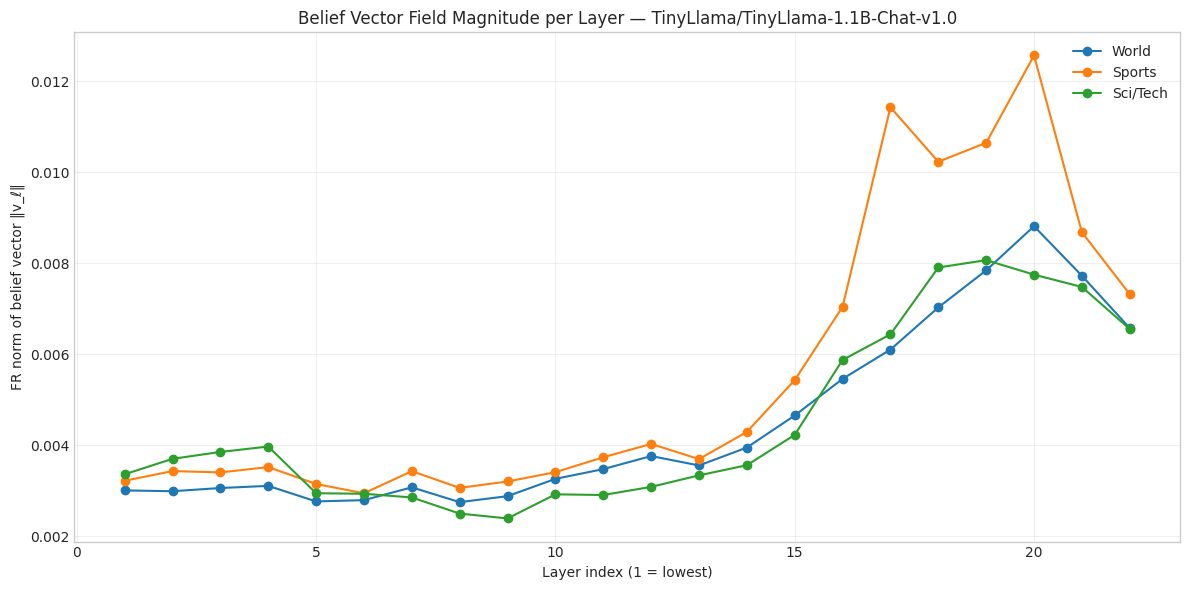

In [ ]:
concept_curves = {}
for name, _ in concept_specs:
    norms = belief_field_for_concept(concept_datasets[name], name)
    concept_curves[name] = norms

plt.figure(figsize=(12,6))
layers = np.arange(1, num_layers+1)
colors = {"World":"tab:blue", "Sports":"tab:orange", "Sci/Tech":"tab:green"}

for name in concept_curves:
    plt.plot(layers, concept_curves[name], marker='o', label=name, color=colors.get(name,None))

ylabel = "FR norm of belief vector ‖v_ℓ‖" if FR_NORM else "Euclidean norm of belief vector ‖v_ℓ‖"
plt.title(f"Belief Vector Field Magnitude per Layer — {MODEL_NAME}")
plt.xlabel("Layer index (1 = lowest)")
plt.ylabel(ylabel)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
